In [9]:
## IMPORTS 
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import random 
import torch
import torchvision 
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as T

#import torchvision
#from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.image as mpimg
import matplotlib.pyplot as plt 


#import splitfolders
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
#from tqdm.notebook import tqdm
import glob
import time
import PIL
from PIL import Image
import os
import cv2
import timm

In [4]:
## IMPORTING THE MIDAS NETWORK

#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type, trust_repo=True)

/home/server/anaconda3/envs/monocular/lib/python3.8/site-packages/torch/hub.py:266: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /home/server/.cache/torch/hub/master.zip


Loading weights:  None


Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /home/server/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /home/server/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.com/intel-isl/MiDaS/releases/download/v2_1/model-small-70d6b9c8.pt" to /home/server/.cache/torch/hub/checkpoints/model-small-70d6b9c8.pt
100%|██████████████████████████████████████| 81.8M/81.8M [00:11<00:00, 7.72MB/s]


In [5]:
## COMPUTATIONAL RESSOURCES 

!nvidia-smi

Wed Aug  3 15:15:25 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   36C    P8     6W / 180W |     68MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
# Activate cuda
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cuda


In [8]:
## BIG DATASET RESIZED 256

# Original images 
full_data_path='data/big_images_dataset_256'


#Associated depth maps
full_depth_maps_path ='data/big_depth_maps_dataset_256'


In [65]:
#LOADING DATA

def load_data(data_path, verbose=False):
    DATA_LOADED=False 
    print_every_n_loads=10
    images=[]
    ind=0
    t0=time.time()
    if not DATA_LOADED:
      print('Loading data...')
      list_dir = os.listdir(data_path)
      list_dir=sorted(list_dir, key=lambda x: x.lower())
      for filename in list_dir:
          if ind<5:
            print(str(filename)) #TO CHECK IF THE PAIRING BETWEEN DEPTHMAPS AND IMAGES IS CORRECT
          img = mpimg.imread(os.path.join(data_path, filename))
          if img is not None:
              images.append(img)
              ind+=1
          if verbose:
              if ind%print_every_n_loads==0:
                  print('nb of data loaded:', ind)
      print(f'Loaded data in: {time.time()-t0 } s')
    return images

images=load_data(full_data_path)
depth_maps=load_data(full_depth_maps_path)

Loading data...
big_images_dataset_256resized_256_20220509T222940.000Z.jpg
big_images_dataset_256resized_256_20220509T222944.000Z.jpg
big_images_dataset_256resized_256_20220509T222948.000Z.jpg
big_images_dataset_256resized_256_20220509T222952.000Z.jpg
big_images_dataset_256resized_256_20220509T222956.000Z.jpg
Loaded data in: 6.632874488830566 s
Loading data...
big_depth_maps_dataset_256resized_256_depth_20220509T222940.000Z.png
big_depth_maps_dataset_256resized_256_depth_20220509T222944.000Z.png
big_depth_maps_dataset_256resized_256_depth_20220509T222948.000Z.png
big_depth_maps_dataset_256resized_256_depth_20220509T222952.000Z.png
big_depth_maps_dataset_256resized_256_depth_20220509T222956.000Z.png
Loaded data in: 7.2136619091033936 s


In [59]:
DATA_LOADED=True
#NUM_TRAIN=len(train_images)
#NUM_VAL=len(val_images)
#NUM_TEST=len(test_images)
#H, W, C=train_images[0].shape
#print(NUM_TRAIN, NUM_VAL, NUM_TEST)
SCALE_FACTOR=1000 #Need to increaze the really small values in the depth_maps data,
# otherwise, during transformation, all elements are set to zero.

In [42]:
## Using different metrics to evaluate performances of the network

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

#A loss robust to outliers + large data values 

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(torch.abs(pred + 1)), torch.log(torch.abs(actual + 10))))

In [93]:
class Original_and_Depth_Map(torch.utils.data.Dataset):

    def __init__(self, listA, listB, transform=None):
        self.listA= listA
        self.listB= listB
        self.datasetA = []
        self.datasetB = []
       
    #Making sure all images have the same size before creating an array
        for el, img in zip(self.listA, self.listB):
            new_imA=el[:,:456,:]
            self.datasetA.append(new_imA)
            new_imB=img[:,:456]
            self.datasetB.append(new_imB)
        self.datasetA=np.array(self.datasetA).astype(np.uint8)
        self.datasetB=(np.array(self.datasetB)*1000).astype(np.uint8)
        
        self.transform= transform
        
    def __getitem__(self, index):
        xA = self.datasetA[index]
        xB = self.datasetB[index]

        if self.transform:
          return self.transform(xA), self.transform(xB)
        
        return xA, xB

    def __len__(self):
        return len(self.datasetA)

In [94]:
# LOADING THE NECESSARY MIDAS TRANSFORM

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform_midas = midas_transforms.dpt_transform
else:
    transform_midas = midas_transforms.small_transform

Using cache found in /home/server/.cache/torch/hub/intel-isl_MiDaS_master


In [127]:
batch_size = 32

# CREATING THE TRAIN VAL AND TEST DATASETS

full_dataset =Original_and_Depth_Map(images, depth_maps)
train_and_eval_size = 2500
test_size = 451
train_and_eval, test_dataset = torch.utils.data.random_split(full_dataset, [train_and_eval_size, test_size])

      
train_size= 2250
val_size = 250
train_dataset, val_dataset = torch.utils.data.random_split(train_and_eval, [train_size, val_size])

#DATALOADERS
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2, pin_memory=True)

In [128]:
#LENGHT TEST 

print(len(train_dataset), len(test_dataset), len(val_dataset))

2250 451 250


In [ ]:
#APPLYING THE NECESSARY TRANSFORMATION TO ALL IMAGES OF THE DATASET
#for image, depthmap in train_loader:
  #for im in image:
    #im = transform_midas(im.numpy())
    #im=torch.from_numpy(np.reshape(im.numpy().astype(np.uint8), (224,384,3)))


#print(im.size())

2339


<Figure size 432x288 with 0 Axes>

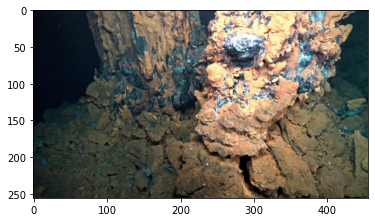

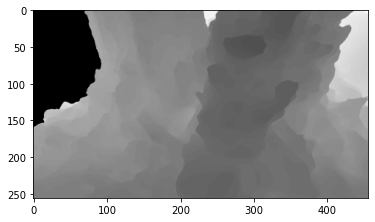

<Figure size 432x288 with 0 Axes>

In [129]:
ind=np.random.randint(2499)
print(ind)
img, d= full_dataset[ind]

plt.imshow(full_dataset[ind][0])
plt.figure()
plt.imshow(full_dataset[ind][1], cmap='gray')
plt.figure()
#ORDRE OK!!

cuda
output size torch.Size([1, 128, 256])
original depth map size torch.Size([256, 456])
tensor(1.2307, device='cuda:0', grad_fn=<SqrtBackward0>)


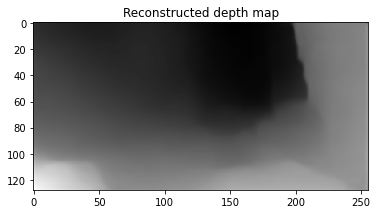

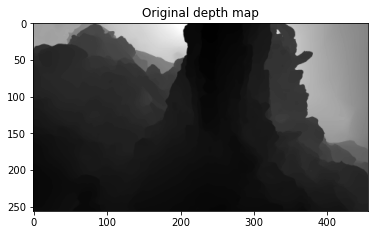

<Figure size 432x288 with 0 Axes>

In [119]:
#CHECKING THAT THE FORWARD FUNCTION WORKS OK, STEP BY STEP
midas.to(device)
loss_function=RMSLELoss()
loss_function.to(device)
print(device)

for image, depth in train_loader:
  #print(image.size())
  #print(depth.size()
  #midas.train()
  depth.to(device)
  image.to(device)
  for im, d in zip(image, depth):
    im=transform_midas(im.numpy()).to(device)
    d.to(device)
    output=midas(im).to(device)
    
    print('output size', output.size())
    plt.imshow(output.cpu().detach().squeeze().numpy(), cmap='gray')
    plt.title('Reconstructed depth map')
    plt.figure()
    plt.title('Original depth map')
    plt.imshow(depth[0],cmap='gray')
    plt.figure()
    print('original depth map size', d.size())
    loss=loss_function(output.squeeze().to(device), d[:128, :256].to(device))
    print(loss)
    break
  break


In [130]:
#Transformation applied to all images 
for image, _ in train_loader:
  for im in image:
    im=transform_midas(im.numpy()).to(device)



In [139]:
#Training function

def train_epoch(network, device, dataloader, optimizer, loss_function, print_every = 20):
    """ Trains the simple model for one epoch. losses_resolution indicates how often training_loss should be printed and stored. """
    network.train()
    network.to(device)
    
    train_losses = []
    rmse_metrics=[]
    rmsle_metrics=[]
    rmse=RMSELoss()
    rmsle=RMSLELoss()

    # Iterate the dataloader (We do not need the label value which is 0 here, the depth maps are the labels)
    iter = 0
    for image, depth_map in dataloader:   
      #Moving to GPU
      image.to(device)
      d = depth_map.to(device)

      #Applying the necessary transforms
      #(transform_midas does not keep the transformations in memory of the dataloader.)
      #Best= apply it the the entire dataset in its definition
      image=np.transpose(image, [0,3,1,2])
      image = image.type(torch.cuda.FloatTensor)
      image=T.functional.resize(image, (128, 256))
      d=d.type(torch.cuda.FloatTensor)


      #Going through the network
      d_hat = network(image)
    

      #Computing the loss, storing it
      d_test=T.functional.resize(d, (128, 256))
      loss=loss_function(d_hat.squeeze(),  d_test).float()

      #Computing metrics, stroring them
      rmse_metric=rmse(d_hat.squeeze(),  d_test).float()
      rmsle_metric=rmsle(d_hat.squeeze(),  d_test).float()

      # Backward pass
      optimizer.zero_grad()  # Sets the gradients attached to the parameters objects to zero.
      loss.backward()  # Uses the gradient object attached to the loss to recursively compute the gradients of the parameters of the network (and store their value in the gradient objects attached to said parameters)
      optimizer.step()  # Actually chages the values of the parameters using their gradients, computed on the previous line of code.
      
      # Print and store batch loss
      batch_loss = loss.item()/d.shape[0]
      train_losses.append(batch_loss)

      #Print and store batch values for metrics 
      batch_rmse=rmse_metric.item()/d.shape[0]
      rmse_metrics.append(batch_rmse)
      
      batch_rmsle=rmsle_metric.item()/d.shape[0]
      rmsle_metrics.append(batch_rmsle)
        
      #Display
      #f iter%print_every == 0:
          #prinf'\t partial train loss (single batch): {batch_loss:.2f}')
    
    return train_losses, rmse_metrics, rmsle_metrics


In [132]:
#First try training loop 
mse= nn.MSELoss()
rmse=RMSELoss()
lr=1e-3
weight_decay=1e-3
optim= torch.optim.Adam(midas.parameters(), lr=lr, weight_decay=weight_decay)

train_losses_epoch, rmse_metrics_epoch, rmsle_metric_epoch = train_epoch(midas, device, train_loader,optim, mse)

	 partial train loss (single batch): 36.98
	 partial train loss (single batch): 40.39
	 partial train loss (single batch): 48.96
	 partial train loss (single batch): 34.09
	 partial train loss (single batch): 35.87
	 partial train loss (single batch): 24.94
	 partial train loss (single batch): 25.41
	 partial train loss (single batch): 17.45
	 partial train loss (single batch): 12.68
	 partial train loss (single batch): 33.55
	 partial train loss (single batch): 37.53
	 partial train loss (single batch): 35.83
	 partial train loss (single batch): 34.55
	 partial train loss (single batch): 38.64
	 partial train loss (single batch): 14.47
	 partial train loss (single batch): 25.51
	 partial train loss (single batch): 27.52
	 partial train loss (single batch): 16.15
	 partial train loss (single batch): 25.47
	 partial train loss (single batch): 27.14
	 partial train loss (single batch): 32.76
	 partial train loss (single batch): 21.78
	 partial train loss (single batch): 19.80
	 partial t

In [133]:
# Trying to get a grasp on the model:

DISPLAY_LAYERS=False
# Print model's state_dict: What is going on inside our model?
print("Model's state_dict:")
if DISPLAY_LAYERS:
    for param_tensor in midas.state_dict():
        print(param_tensor, "\t", midas.state_dict()[param_tensor].size())

Model's state_dict:


In [134]:
## Testing function

def validation_epoch(network, device, loss_function, dataloader):
    "Set evaluation mode for encoder and decoder"
    network.to(device)
    network.eval()  # evaluation mode, equivalent to "network.train(False)""
    val_loss = 0
    with torch.no_grad(): # No need to track the gradients
        for image, depth_map in dataloader:
            #Moving to GPU
            image.to(device)
            d = depth_map.to(device)

            #Applying the necessary transforms
            #(transform_midas does not keep the transformations in memory of the dataloader.)
            #Best= apply it the the entire dataset in its definition
            image=np.transpose(image, [0,3,1,2])
            image = image.type(torch.cuda.FloatTensor)
            image=T.functional.resize(image, (128, 256))
            d=d.type(torch.cuda.FloatTensor)


            #Going through the network
            d_hat = network(image)
          

            #Computing the loss, storing it
            d_test=T.functional.resize(d, (128, 256))
            loss=loss_function(d_hat.squeeze(),  d_test).float()
            val_loss += loss.item()/d.shape[0]

    return val_loss/len(dataloader)


In [135]:
#Plotting the learning and validation loss curves


def plot_learning_curves(train_losses, val_losses, rmse_metrics, rmsle_metrics):
    """ Plots the learning curve. Losses resolution (how many times the loss is displayed) is one value per batch for the training losses, and one value per epoch for the validation. """
    iterations_train = np.arange(0, batch_size*train_losses.size, batch_size)
    iterations_validation = np.arange(0, train_size*val_losses.size, train_size)

    fig, ax = plt.subplots(figsize=(10, 10))
    #What happens during training 
    ax.plot(iterations_train, train_losses, color="blue", label="training loss")
    ax.plot(iterations_train, rmse_metrics, color="red", label="RMSE")
    ax.plot(iterations_train, rmsle_metrics, color="green", label="RMSLE")

    #What happens during validation
    ax.plot(iterations_validation, val_losses, color="orange", label = "validation loss")
    
    ax.set(xlabel="iterations", ylabel="loss", title="Training and validation losses over iterations")
    ax.grid()
    ax.legend()

    fig.show()

In [136]:
## Plotting function

def plot__outputs(network, number_outputs=5, random_plots=True, indices=None, title=None):
  """
    When random_plots = True, different images are taken between each epoch.
    When random_plots = False, indices indicates what images to plot
  """
  fig = plt.figure(figsize=(5*number_outputs,8.5))
  if title is not None:
    fig.suptitle(f'Results at the end of epoch {title}',  fontsize='large', fontweight='bold')
  
  #Selection of random images to plot within the dataset or a select set of indices
  if random_plots:
      plotted_samples = np.random.choice(test_size, number_outputs)
  else:
      plotted_samples = indices
  
  for i in range(number_outputs):
      ax = plt.subplot(3, number_outputs, i+1)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      # plt.subplot(nb_rows, nb_cols, num)  where num is indexed from 1
      image = test_dataset[plotted_samples[i]][0]
      plt.imshow(image)
      
      #image = next(iter(test_loader))
      network.train()
      
      with torch.no_grad():
        
        #NECESSARY TRANSFORMS
        np.transpose(image, [2,0,1])
        transform=T.ToTensor()
        image=transform(image)
        image=T.functional.resize(image, (128, 256))
        image = image.type(torch.FloatTensor)
        image=image.unsqueeze(0).to(device)
        output_img  = network(image)

      #right_size_im=np.transpose(im.cpu().squeeze().numpy(), (1, 2, 0))
      #plt.imshow(right_size_im*255)
      plt.imshow(test_dataset[plotted_samples[i]][0])
      if i == number_outputs//2:
          ax.set_title('Original images')
    
      

      ax = plt.subplot(3, number_outputs, i + 1 + number_outputs)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      plt.imshow(output_img.cpu().squeeze().numpy(), cmap='gray')
      if i == number_outputs//2:
          ax.set_title('Reconstructed depth maps')
      
      ax=plt.subplot(3, number_outputs, i + 1 + 2*number_outputs)
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

      #plt.imshow(test_dataset[plotted_samples[i]][1], cmap='gray')
      plt.imshow(test_dataset[plotted_samples[i]][1], cmap='gray')
      if i == number_outputs//2:
          ax.set_title('Original depth maps')



 EPOCH 1/6 	 train loss 1.006 	 val loss 13.973 	 RMSE 2.343 	 RMSLE 0.099

 EPOCH 2/6 	 train loss 0.754 	 val loss 12.278 	 RMSE 1.827 	 RMSLE 0.098

 EPOCH 3/6 	 train loss 0.715 	 val loss 10.807 	 RMSE 2.047 	 RMSLE 0.099

 EPOCH 4/6 	 train loss 1.498 	 val loss 9.453 	 RMSE 2.149 	 RMSLE 0.086

 EPOCH 5/6 	 train loss 0.861 	 val loss 10.645 	 RMSE 1.733 	 RMSLE 0.072

 EPOCH 6/6 	 train loss 0.468 	 val loss 10.697 	 RMSE 1.201 	 RMSLE 0.074


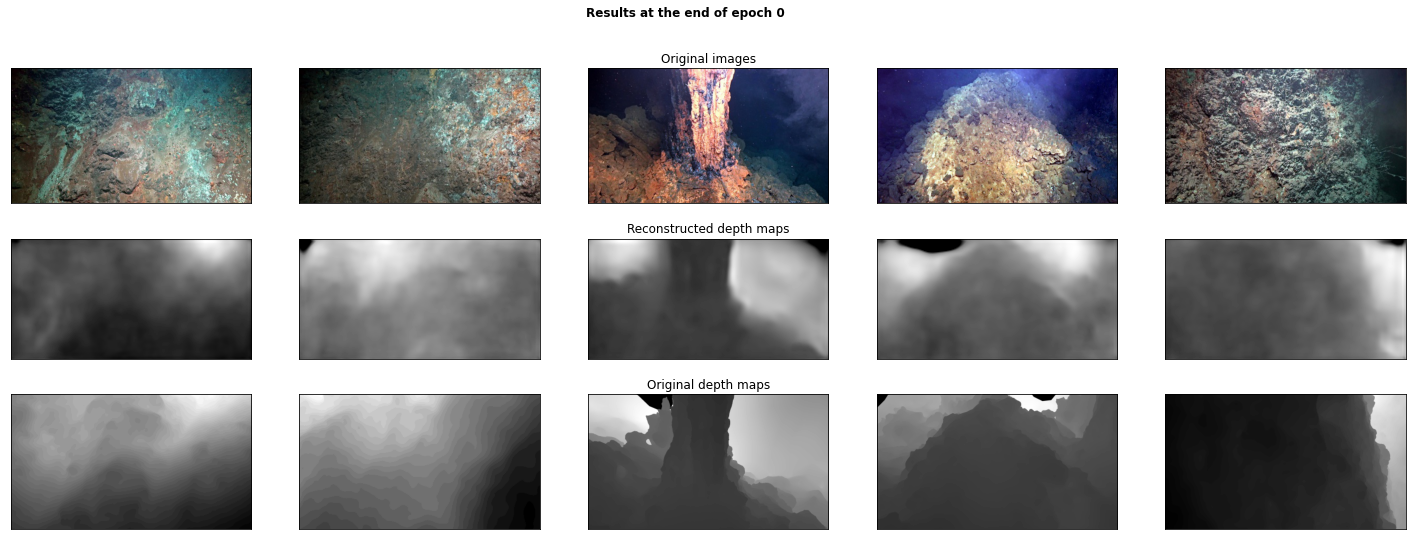

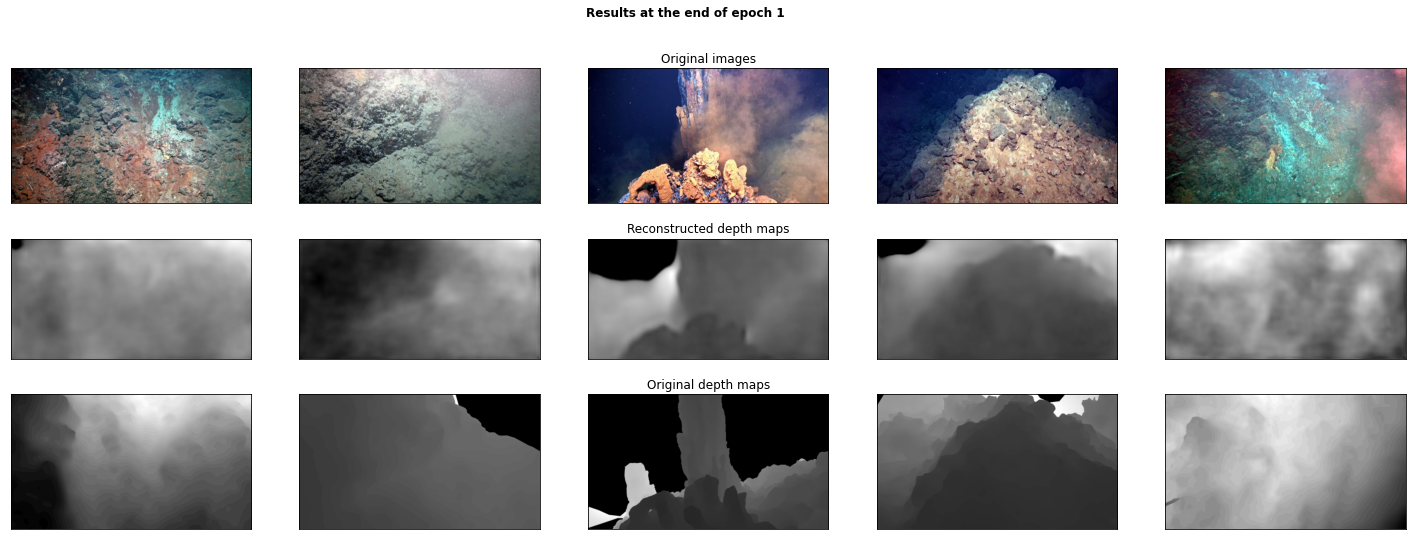

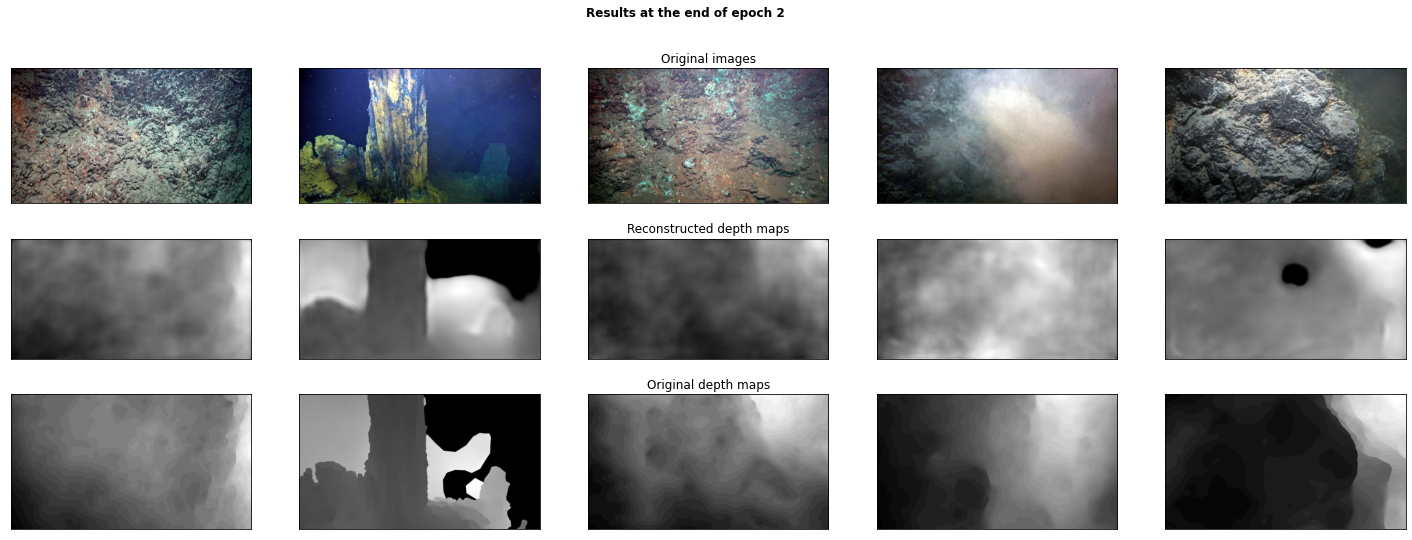

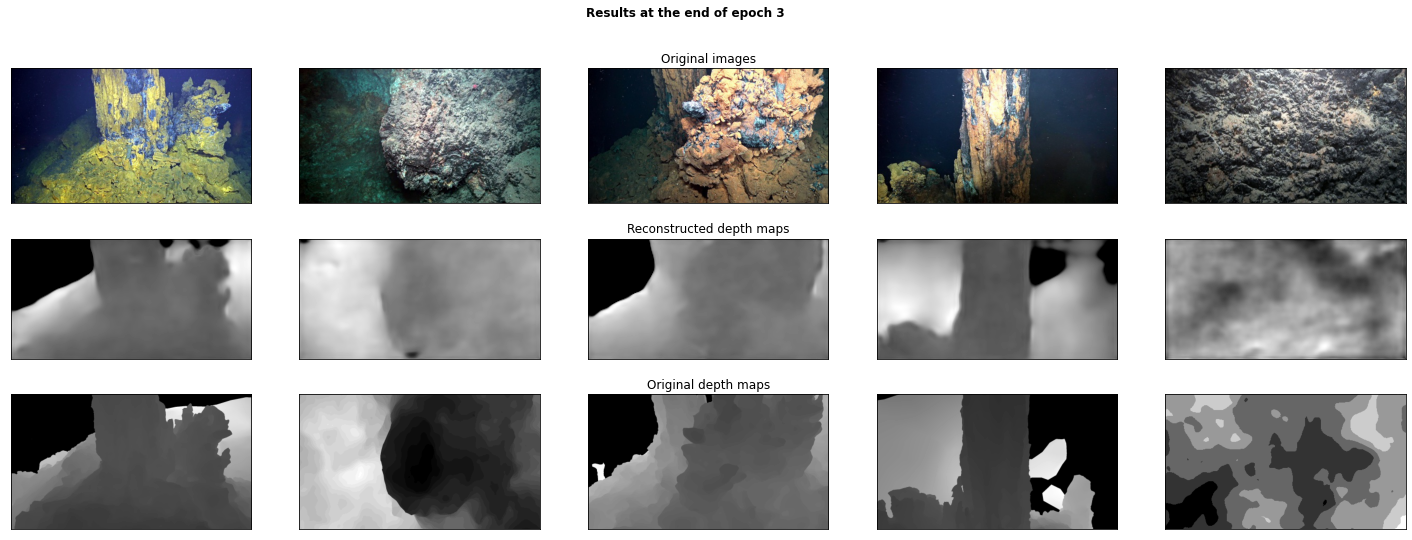

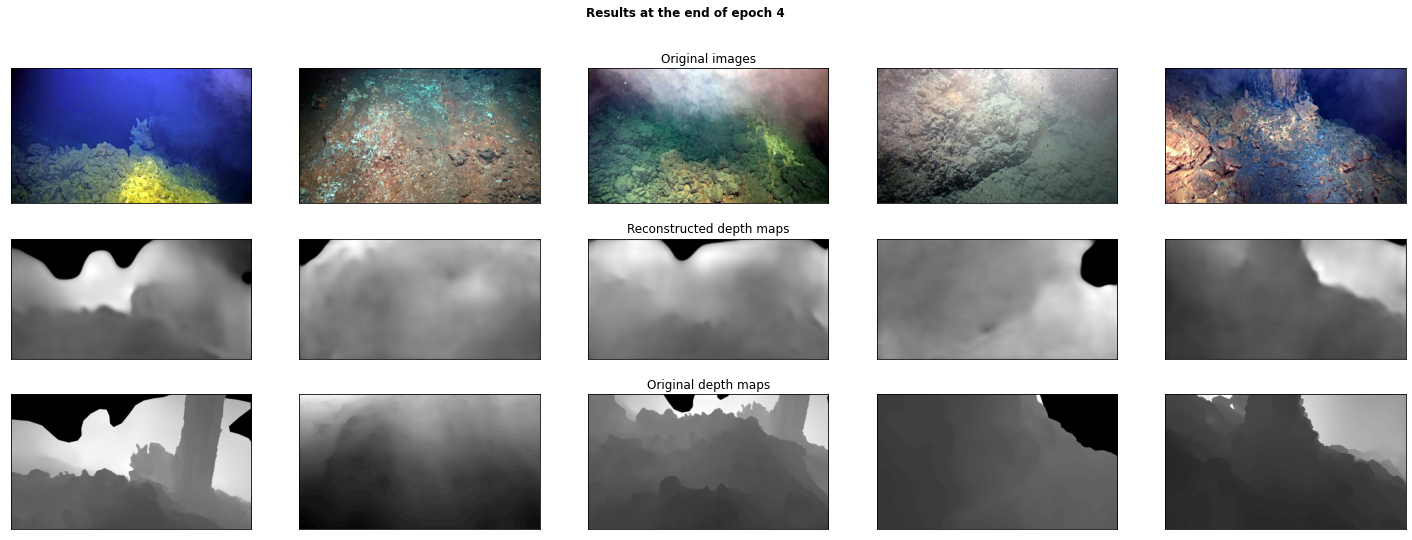

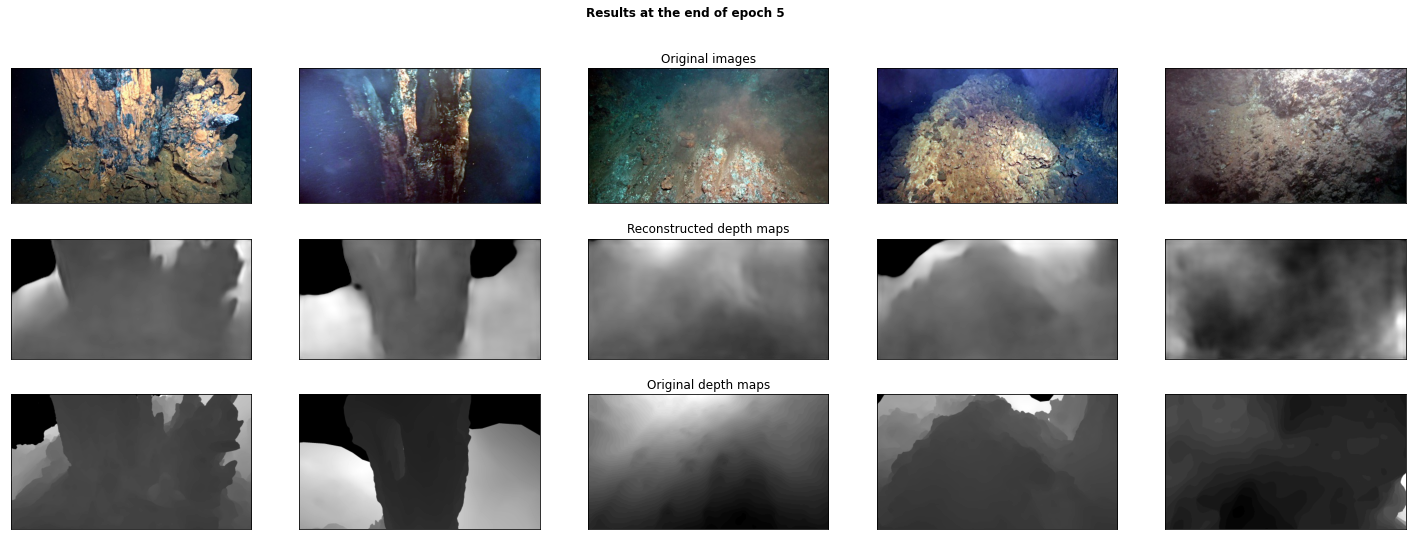

In [140]:
## Training and Validation processes


## Choice of different parameters
lr=1e-3
weight_decay=1e-4 #Weight regularization to avoid overfitting
number_of_plotted_images = 5
plot_images_every_n_epochs = 2
random_plots = True
indices_to_plot = np.arange(number_of_plotted_images)
num_epochs= 6
optim=torch.optim.Adam(midas.parameters(), lr=lr, weight_decay=weight_decay)

## Choice of the loss
mse=nn.MSELoss()
l1=nn.L1Loss()
rmse=RMSELoss()
rmsle=RMSLELoss()


train_losses = np.array([])
rmse_metrics=np.array([])
rmsle_metrics=np.array([])
val_losses = np.array([validation_epoch(midas, device, mse, val_loader)])


## Training process

for epoch in range(num_epochs):
   train_losses_epoch, rmse_metrics_epoch, rmsle_metrics_epoch = train_epoch(midas, device, train_loader,optim, l1, print_every=100)
   val_loss_epoch = validation_epoch(midas, device, mse, val_loader)
   train_losses = np.concatenate((train_losses, train_losses_epoch))
   rmse_metrics=np.concatenate((rmse_metrics, rmse_metrics_epoch))
   rmsle_metrics=np.concatenate((rmsle_metrics, rmsle_metrics_epoch))
   val_losses = np.append(val_losses, val_loss_epoch)
   
   print(f'\n EPOCH {epoch + 1}/{num_epochs} \t train loss {train_losses_epoch[-1]:.3f} \t val loss {val_loss_epoch:.3f} \t RMSE {rmse_metrics_epoch[-1]:.3f} \t RMSLE {rmsle_metrics_epoch[-1]:.3f}')

   #Plotting reconstruction results at the end of each epoch to see the evolution
   plot__outputs(midas, number_outputs=number_of_plotted_images, random_plots=random_plots, indices=indices_to_plot, title=epoch)


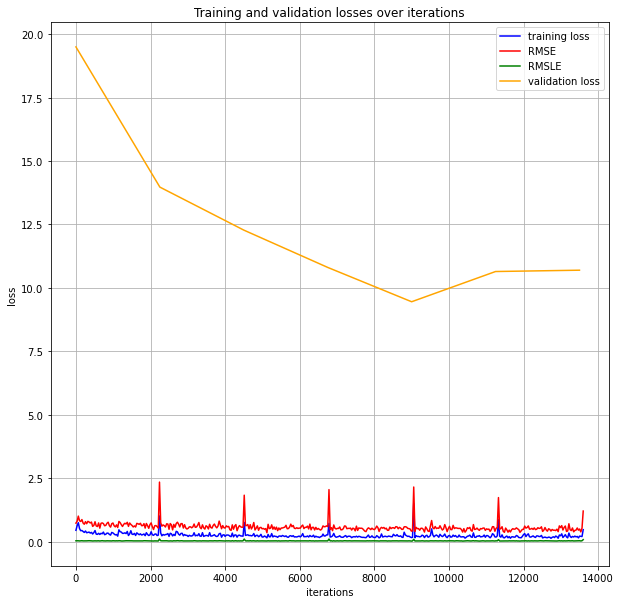

In [141]:
# Losses with medium_structure_model
plot_learning_curves(train_losses, val_losses, rmse_metrics, rmsle_metrics)


**Thoughts**

The validation loss is way bigger than the training loss. Does it means that the network already overfits? Not much change in terms of RMSE and RMSLE, but it is maybe normal as I do not compute them efficiently. STill need to change this+ See for the new organisation of data (test/train dataset).